In [1]:
import numpy as np
import matplotlib.pyplot as plt
from preprocess_images import data_from_folder
from tqdm import tqdm

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import cv2 
import wandb

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [3]:
data = data_from_folder("./data/125x125_laser_x4_y6", grayscale=True)
# data = data_from_folder("./data/laser_x4_y6")
# data = data_from_folder("./data/test")

x-0.00_y-0.10.jpg


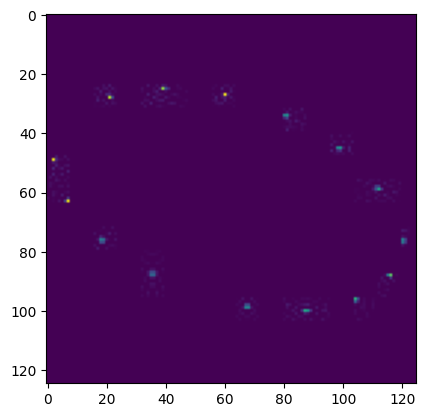

In [4]:
for k in data:
    print(k)
    plt.imshow(data[k], vmin=0, vmax=255)
    # plt.show()
    break

In [4]:
def imname_to_target(name:str) -> tuple[float]:
    """Parses image names of format x{x_value}_y{y_value}.jpg"""
    name = name.split('.jpg')[0]
    x, y = name.split("_")
    x = float(x[1:])
    y = float(y[1:5])
    return x, y

In [ ]:
print(imname_to_target("x0.00_y1.93-light.jpg"))

(0.0, 1.93)


In [6]:
class ImageDataset(Dataset):
    def __init__(self, images, targets, transform=None):
        self.images = images
        self.targets = targets
        self.transform = transform

        self.in_channels = 3
        if len(self.images[0].shape) == 2:
            self.in_channels = 1
        else:
            self.in_channels = self.images[0].shape[2] # TODO check
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index]  # Get image (NumPy array)
        label = self.targets[index]  # Get corresponding tuple

        # Convert image to Tensor and normalize [0,1]
        image = torch.from_numpy(image)
        if len(image.shape)==3:
            image = image.permute(2, 0, 1)  # HWC -> CHW
        else:
            image = image.unsqueeze(0)
        image = image.float() / 255.0

        # Convert label tuple to Tensor
        label = torch.tensor(label, dtype=torch.float32)

        # Apply transforms if specified
        if self.transform:
            image = self.transform(image)

        return image, label


class FlatGrayImageDataset(Dataset):
    def __init__(self, images, targets):
        self.images = images
        self.targets = targets
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index]  # Get image (NumPy array)
        label = self.targets[index]  # Get corresponding tuple
        
        # Convert image to Tensor, flatten, and normalize [0,1]
        image = torch.from_numpy(image).flatten()
        image = image.float() / 255.0
        
        # Convert label tuple to Tensor
        label = torch.tensor(label, dtype=torch.float32)

        return image, label

In [7]:
a = np.zeros((125, 125))
a = torch.from_numpy(a)
print(a.shape)
a = a.flatten()
print(a.shape)

torch.Size([125, 125])
torch.Size([15625])


In [8]:
config = {
    "experiment_name": "initial_kan",
    "batch_size": 4000,
    "lr": 0.001,
    "lr_scheduler_loop": 15,
    "epochs": 55,
}

In [9]:
# Prepare dataset
images = []
targets = []
for name, image in data.items():
    targets.append(imname_to_target(name))
    images.append(image)
# dataset = ImageDataset(images, targets)
dataset = FlatGrayImageDataset(images, targets)
data_loader = DataLoader(dataset, config["batch_size"], True)

In [10]:
print(dataset[0][0].shape)
# print(dataset.in_channels)

torch.Size([15625])


In [14]:
class SimpleCNN(nn.Module):
    def __init__(self, output_size, in_channels):
        super(SimpleCNN, self).__init__()
        self.sec1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 5, 2), # 3, 250 -> 32, 125
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32, 125 -> 32, 62

            nn.Conv2d(32, 64, 3, 2), # 32, 62 -> 64, 31
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64, 31 -> 64, 15

            nn.Conv2d(64, 128, 3, 2), # 64, 15 -> 128, 7
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128, 7 -> 128, 3
        )

        self.sec2 = nn.Sequential(
            nn.Linear(128*3*3, 256),
            nn.ReLU(),
            nn.Linear(256, output_size),
        )

    def forward(self, x):
        x = self.sec1(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.sec2(x)

        return x
    
class SimpleFC(nn.Module):
    def __init__(self, out_features):
        super(SimpleFC, self).__init__()
        self.relu = nn.ReLU()
        self.layers = nn.Sequential(
            nn.Linear(125*125, 1024), # 15,625 -> 1024
            nn.BatchNorm1d(1024),
            self.relu,
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            self.relu,
            nn.Linear(256, 32),
            nn.BatchNorm1d(32),
            self.relu,
            nn.Linear(32, out_features),
        )
    def forward(self, x):
        return self.layers.forward(x)
        

In [ ]:
from kan import KAN

In [15]:
# model = SimpleCNN(output_size=2, in_channels=data_loader.in_channels).to(DEVICE)
# summary(model, (data_loader.in_channels, 250, 250))


model = SimpleFC(2).to(DEVICE)
summary(model, (125*125,), config["batch_size"])

optimizer = optim.AdamW(model.parameters(), config["lr"])
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, config["lr_scheduler_loop"], eta_min=0.00001)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [4000, 1024]      16,001,024
       BatchNorm1d-2               [4000, 1024]           2,048
              ReLU-3               [4000, 1024]               0
              ReLU-4               [4000, 1024]               0
            Linear-5                [4000, 256]         262,400
       BatchNorm1d-6                [4000, 256]             512
              ReLU-7                [4000, 256]               0
              ReLU-8                [4000, 256]               0
            Linear-9                 [4000, 32]           8,224
      BatchNorm1d-10                 [4000, 32]              64
             ReLU-11                 [4000, 32]               0
             ReLU-12                 [4000, 32]               0
           Linear-13                  [4000, 2]              66
Total params: 16,274,338
Trainable para

In [16]:
def save_model(model:torch.nn.Module, fname="best_model.pth", path="./saved_models/"):
    torch.save(model.state_dict(), path+fname)

def load_model(model:torch.nn.Module, fname="best_model.pth", path="./saved_models/"):
    model.load_state_dict(torch.load(path+fname, weights_only=False))

In [17]:
wandb.login(key="a41d74c58ab2f0d2c2bbdb317450ab14a8ad9d4e")
wandb.init(
    project="multireflection",
    name=config["experiment_name"],
    config=config,
)
wandb.watch(model, log='all', log_freq=100)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/evv/.netrc
wandb: Currently logged in as: e-venediktov (e-venediktov-university-of-pittsburgh) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [18]:
def train(model, data_loader, optimizer:optim.Optimizer, criterion, scheduler:optim.lr_scheduler.CosineAnnealingWarmRestarts):
    best_loss = 1000000000
    best_model = None

    # Training Loop
    for epoch in range(config['epochs']):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(data_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        last_lr = scheduler.get_last_lr()[0]
        scheduler.step()

        avg_train_loss = running_loss / len(data_loader)
        print(f"Epoch {epoch + 1}/{config['epochs']}, Train Loss: {avg_train_loss:.4f}")

        if avg_train_loss < best_loss:
            best_model = model
            best_loss = avg_train_loss
            save_model(model, fname=config["experiment_name"]+"_best_model.pth")

        # ✅ Log Training Loss
        wandb.log({"Train Loss": avg_train_loss, "LR": last_lr, "best_loss":best_loss})

    print("Best loss:", best_loss)
    return model, best_model


In [ ]:
model, best = train(model, data_loader, optimizer, criterion, scheduler)

In [20]:
wandb.finish()

LR,▆▁▇▅▃▄▂▁▆▅▂▁█▅▅▂▂▁██▅▅▂▁█▄▃▁▁▇▂██▇▄▁█▇▇▁
Train Loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_loss,█▆▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LR,1e-05
Train Loss,0.29696
best_loss,0.22097


In [57]:
def prepare_test_input(data_folder:str, fnames:list[str], device):
    tensors = []
    targets = []
    original_images = [] # for visualization
    for fname in fnames:
        img = cv2.imread(data_folder+fname, cv2.IMREAD_GRAYSCALE)
        original_images.append(img)
        img = torch.from_numpy(img).flatten()
        img = img.float() / 255.0
        tensors.append(img)

        targets.append(imname_to_target(fname))
    result_tensor = torch.stack(tensors).to(device)

    return result_tensor, targets, original_images

In [67]:
# Prepare test images
data_folder = "data/125x125_laser_x4_y6/"
fnames = [
    "x-3.00_y-2.10.jpg",
    "x-2.90_y1.40.jpg",
    "x-1.70_y2.00.jpg",

    "x-1.10_y1.40.jpg",
    "x-0.60_y2.10.jpg",
    "x1.30_y-0.90.jpg",

    "x-0.00_y-0.10.jpg",
    "x-0.00_y0.00.jpg",
    "x0.80_y0.10.jpg",
]
test_input, targets, original_images = prepare_test_input(data_folder, fnames, DEVICE)
print(test_input.shape)
print(targets)


torch.Size([9, 15625])
[(-3.0, -2.1), (-2.9, 1.4), (-1.7, 2.0), (-1.1, 1.4), (-0.6, 2.1), (1.3, -0.9), (-0.0, -0.1), (-0.0, 0.0), (0.8, 0.1)]


In [68]:
# Try best model
best.eval()

predictions:torch.Tensor = best.forward(test_input)
predictions = predictions.detach().cpu().numpy()
print(predictions)

[[-3.0065970e+00 -2.1079493e+00]
 [-2.8733420e+00  1.3664374e+00]
 [-1.5833652e+00  2.0146189e+00]
 [-1.0652933e+00  1.3912892e+00]
 [-5.9250635e-01  2.0755947e+00]
 [ 1.3025875e+00 -9.3567246e-01]
 [ 2.9101685e-02 -1.3791536e-01]
 [ 5.4039061e-04 -3.4791987e-02]
 [ 9.1088736e-01  1.4007729e-01]]


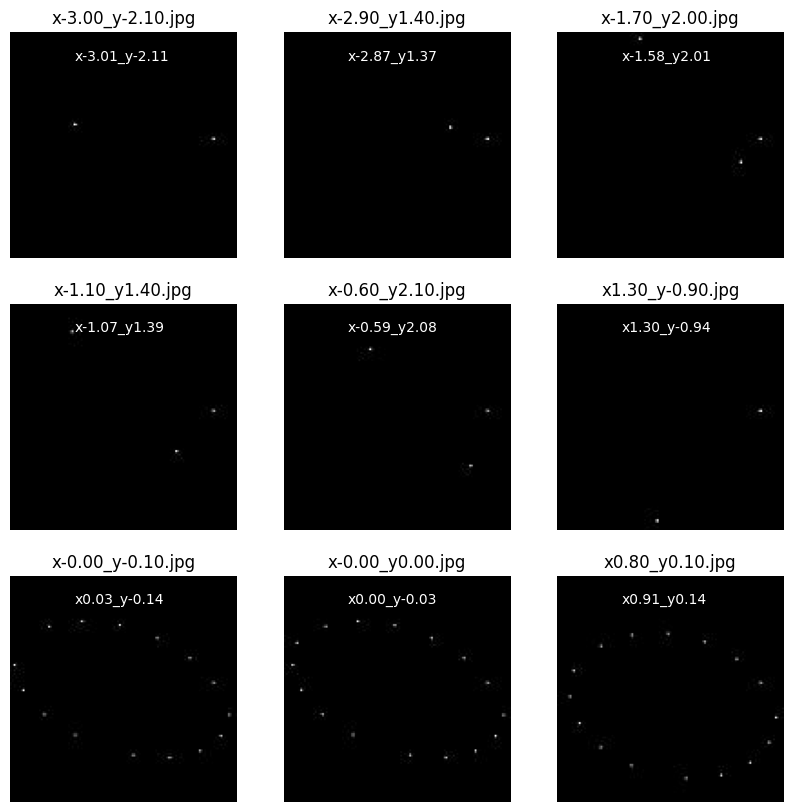

In [69]:
# Visualize
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(original_images[i], cmap='gray')
    ax.set_title(fnames[i])
    ax.axis("off")

    # Display prediction
    ax.text(35,15,f"x{predictions[i][0]:.2f}_y{predictions[i][1]:.2f}", color="white")

plt.show()

In [ ]:
ntargets = np.array(dataset.targets)
print(ntargets.shape)

evaluate_on_train_loader = DataLoader(dataset, batch_size=config["batch_size"], shuffle=False)

(4290, 2)
